In [1]:
import torch
import numpy as np
import random
from IPython import display
from matplotlib import pyplot as plt
from torch import nn
import torch.utils.data as Data
import torch.optim as optim
from torch.nn import init
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"  #防止jupyter崩溃

In [2]:
#自定义数据---训练集
num_inputs = 200
#1类
x1 = torch.normal(2,1,(10000, num_inputs))
y1 = torch.ones(10000,1) # 标签1 
x1_train = x1[:7000]
x1_test = x1[7000:]
#0类
x2 = torch.normal(-2,1,(10000, num_inputs))
y2 = torch.zeros(10000,1) # 标签0
x2_train = x2[:7000]
x2_test = x2[7000:]
#合并训练集
# 注意 x, y 数据的数据形式一定要像下面一样 (torch.cat 是合并数据)---按行合并
trainfeatures = torch.cat((x1,x2), 0).type(torch.FloatTensor)
trainlabels = torch.cat((y1, y2), 0).type(torch.FloatTensor)
print(trainfeatures.shape,trainlabels.shape)


torch.Size([20000, 200]) torch.Size([20000, 1])


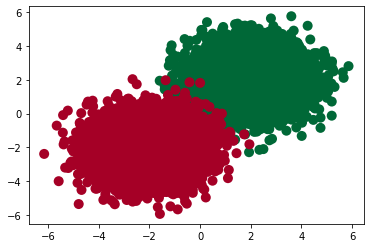

In [3]:
plt.scatter(trainfeatures.data.numpy()[:, 0], trainfeatures.data.numpy()[:, 1], c=trainlabels.data.numpy(), s=100, lw=0,
cmap='RdYlGn')

In [4]:
batch_size = 50

In [5]:
#实现FlattenLayer层
class FlattenLayer(torch.nn.Module):
    def __init__(self):
         super(FlattenLayer, self).__init__()
    def forward(self, x):
        return x.view(x.shape[0],-1)

In [6]:
#模型定义和参数初始化
num_hiddens,num_outputs = 256,1
net = nn.Sequential(
        FlattenLayer(),
        nn.Linear(num_inputs,num_hiddens),
        nn.ReLU(),
        nn.Linear(num_hiddens,num_outputs)
        )

for params in net.parameters():
    init.normal_(params,mean=0,std=0.01)

In [7]:
lr = 0.0005
#定义交叉熵损失函数
loss = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(net.parameters(),lr)

In [8]:
#定义测试集准确率函数
def evaluate_accuracy(test_iter):
    acc_sum,n = 0.0,0
    for X,y in test_iter:
        y_hat = net(X)
        y_hat = torch.squeeze(torch.where(y_hat>0.5,torch.tensor(1.0),torch.tensor(0.0)))
        y=torch.squeeze(torch.where(y>0.5,torch.tensor(1.0),torch.tensor(0.0)))
        acc_sum += (y_hat==y).float().sum().item()
        n+=y.shape[0]
    return acc_sum/n

In [9]:
#定义模型训练函数
def train(net,train_iter,test_iter,loss,num_epochs,batch_size,trainfeatures,trainlabels,testfeatures,testlabels,params=None,lr=None,optimizer=None):
    train_ls = []
    test_ls = []
    for epoch in range(num_epochs): # 训练模型一共需要num_epochs个迭代周期
        train_l_sum, train_acc_num,n = 0.0,0.0,0
        # 在每一个迭代周期中，会使用训练数据集中所有样本一次
        for X, y in train_iter: # x和y分别是小批量样本的特征和标签
            y_hat = net(X)
            l = loss(y_hat, y.view(-1,1)) # l是有关小批量X和y的损失
            #梯度清零
            if optimizer is not None:
                optimizer.zero_grad()
            elif params is not None and params[0].grad is not None:
                for param in params:
                    param.grad.data.zero_()
            l.backward() # 小批量的损失对模型参数求梯度
            if optimizer is None:
                SGD(params,lr)
            else:
                optimizer.step()
            #计算每个epoch的loss
            train_l_sum += l.item()*y.shape[0]
            #计算训练样本的准确率
            y_hat = torch.squeeze(torch.where(y_hat>0.5,torch.tensor(1.0),torch.tensor(0.0)))
            y=torch.squeeze(torch.where(y>0.5,torch.tensor(1.0),torch.tensor(0.0)))
            train_acc_num += (y_hat==y).sum().item()
            #每一个epoch的所有样本数
            n+= y.shape[0]
        
        train_labels = trainlabels.view(-1,1)
        test_labels = testlabels.view(-1,1)
        train_acc=train_acc_num/n
        test_acc=evaluate_accuracy(test_iter)
        train_ls.append(train_l_sum/n)
        test_ls.append(loss(net(testfeatures),test_labels).item())
    print('epoch %d, train_loss %.6f,test_loss %f train_acc %f test_acc %f'%(epoch+1, train_ls[epoch],test_ls[epoch],train_acc,test_acc))
    return train_ls[epoch],test_ls[epoch],train_acc,test_acc

In [10]:
def get_kfold_data(k,i,X,y):
    """
    k:一个K折
    i:第几折
    X:
    """
    fold_size=X.shape[0]//k  # X是数据集，将所有数据集分为K份
    val_start=i*fold_size  #
    
    if i!=k-1: # 不是最后一折
        val_end=(i+1)*fold_size   
        
        ## 验证集
        X_valid,y_valid =X[val_start:val_end],y[val_start:val_end]
        ## 训练集
        X_train=torch.cat((X[0:val_start],X[val_end:]),dim=0)
        y_train=torch.cat((y[0:val_start],y[val_end:]),dim=0)
    else:
        X_valid,y_valid=X[val_start:],y[val_start:]  # 若不能整除，将多的样本放在最后一折里
        X_train=X[0:val_start]
        y_train=y[0:val_start]
    return X_train,y_train,X_valid,y_valid

In [11]:
def k_fold(k,X_train,y_train):
    train_loss_sum,valid_loss_sum= 0,0
    train_acc_sum,test_acc_sum=0,0
    for i in range(k):
        print("第",i+1,"折验证结果")
        X_train,y_train,X_valid,y_valid=get_kfold_data(k,i,X_train,y_train)  # 获取K折的训练集和验证集
        train_dataset = Data.TensorDataset(X_train, y_train)
        test_dataset = Data.TensorDataset(X_valid, y_valid)
        
        train_iter = Data.DataLoader(
                dataset=train_dataset, # torch TensorDataset format
                batch_size=batch_size, # mini batch size
                shuffle=True, # 是否打乱数据 (训练集一般需要进行打乱)
                num_workers=0, # 多线程来读数据， 注意在Windows下需要设置为0
                    )
        test_iter = Data.DataLoader(
                dataset=test_dataset, # torch TensorDataset format
                batch_size=batch_size, # mini batch size
                shuffle=True, # 是否打乱数据 (训练集一般需要进行打乱)
                num_workers=0, # 多线程来读数据， 注意在Windows下需要设置为0
                    )
        lr = 0.01
        #损失函数和优化器
        loss = torch.nn.MSELoss()
        optimizer = torch.optim.SGD(net.parameters(),lr)
        for params in net.parameters():
            init.normal_(params,mean=0,std=0.01) #每轮训练都重新初始化参数
        train_loss,test_loss,train_acc,test_acc = train(net,train_iter,test_iter,loss,num_epochs,batch_size,X_train,y_train,X_valid,y_valid,net.parameters,lr,optimizer)
        train_loss_sum+=train_loss
        valid_loss_sum+=test_loss
        train_acc_sum+=train_acc
        test_acc_sum+=test_acc
    print("\n最终k折交叉验证结果：")
    print("average train loss:{:.4f},average valis loss:{:.4f}".format(train_loss_sum/k,valid_loss_sum/k))
    print("average train accuracy:{:.4f},average test accuracy:{:.4f}".format(train_acc_sum/k,test_acc_sum/k))
    return

In [12]:
#训练次数和学习率
num_epochs = 20
k_fold(10,trainfeatures,trainlabels)

第 1 折验证结果
epoch 20, train_loss 0.000460,test_loss 0.001043 train_acc 1.000000 test_acc 1.000000
第 2 折验证结果
epoch 20, train_loss 0.000414,test_loss 0.001090 train_acc 1.000000 test_acc 1.000000
第 3 折验证结果
epoch 20, train_loss 0.000345,test_loss 0.001105 train_acc 1.000000 test_acc 1.000000
第 4 折验证结果
epoch 20, train_loss 0.000373,test_loss 0.000232 train_acc 1.000000 test_acc 1.000000
第 5 折验证结果
epoch 20, train_loss 0.000414,test_loss 0.000030 train_acc 1.000000 test_acc 1.000000
第 6 折验证结果
epoch 20, train_loss 0.000466,test_loss 0.000036 train_acc 1.000000 test_acc 1.000000
第 7 折验证结果
epoch 20, train_loss 0.000495,test_loss 0.000039 train_acc 1.000000 test_acc 1.000000
第 8 折验证结果
epoch 20, train_loss 0.000572,test_loss 0.000053 train_acc 1.000000 test_acc 1.000000
第 9 折验证结果
epoch 20, train_loss 0.000640,test_loss 0.000069 train_acc 1.000000 test_acc 1.000000
第 10 折验证结果
epoch 20, train_loss 0.000681,test_loss 0.000087 train_acc 1.000000 test_acc 1.000000

最终k折交叉验证结果：
average train loss:0.0005,